# Changelog

### Version 9

* Lower min_df for TF-IDF from 25 to 10
* Increase n_estimators from 100 to 150

### Version 8

* Use LightGBM
* Load dataset from prepared parquet
* Use 3-gram for TF-IDF

### Version 3

* Change TF-IDF param
* More trees
* Denser trees
* Lower LR
* Lower or upper token depends on total lower/upper char

### Version 1

* Initialize code

# Library

In [1]:
!pip install pyenchant pysastrawi

     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 210 kB 16.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!wget http://archive.ubuntu.com/ubuntu/pool/main/libr/libreoffice-dictionaries/hunspell-id_6.4.3-1_all.deb
!dpkg -i hunspell-id_6.4.3-1_all.deb

--2020-07-31 13:20:51--  http://archive.ubuntu.com/ubuntu/pool/main/libr/libreoffice-dictionaries/hunspell-id_6.4.3-1_all.deb
Resolving archive.ubuntu.com (archive.ubuntu.com)... 91.189.88.152, 91.189.88.142, 2001:67c:1360:8001::24, ...
Connecting to archive.ubuntu.com (archive.ubuntu.com)|91.189.88.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143836 (140K) [application/x-debian-package]
Saving to: ‘hunspell-id_6.4.3-1_all.deb’

hunspell-id_6.4.3-1 100%[===================>] 140.46K  --.-KB/s    in 0.03s   

2020-07-31 13:20:51 (4.17 MB/s) - ‘hunspell-id_6.4.3-1_all.deb’ saved [143836/143836]

Selecting previously unselected package hunspell-id.
(Reading database ... 107461 files and directories currently installed.)
Preparing to unpack hunspell-id_6.4.3-1_all.deb ...
Unpacking hunspell-id (1:6.4.3-1) ...
Setting up hunspell-id (1:6.4.3-1) ...


In [3]:
!apt update && apt install -y enchant libenchant1c2a hunspell hunspell-en-us libhunspell-1.6-0

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [3724 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6384 B]
Get:6 http://packages.cloud.google.com/apt cloud-sdk InRelease [6349 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1413 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [116 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1334 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/multiverse amd64 Packages [27.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports/universe amd64 Packages [8432 B]
Get:13 http://packages.cloud.google.com/apt clo

In [4]:
import re
import os
import random

import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import enchant
import lightgbm as lgbm

In [5]:
!pip freeze > requirements.txt

In [6]:
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)
print('NLTK version:', nltk.__version__)
print('LightGBM version:', lgbm.__version__)

Numpy version: 1.18.5
Pandas version: 1.0.3
Scikit-Learn version: 0.23.1
Matplotlib version: 3.2.1
Seaborn version: 0.10.0
NLTK version: 3.2.4
LightGBM version: 2.3.1


In [7]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset

In [9]:
!ls /kaggle/input

shopee-review-cleaned  student-shopee-code-league-sentiment-analysis
shopee-reviews


In [10]:
X_train = pd.read_parquet('/kaggle/input/shopee-review-cleaned/X_train.parquet', engine='pyarrow')
X_train = X_train['X']

X_test = pd.read_parquet('/kaggle/input/shopee-review-cleaned/X_test.parquet', engine='pyarrow')
X_test = X_test['X']

y_train = pd.read_parquet('/kaggle/input/shopee-review-cleaned/y_train.parquet', engine='pyarrow')
y_train = y_train['y']

# Class Weight

In [11]:
rating_count = y_train.value_counts().sort_index().to_list()
total_rating = sum(rating_count)
lowest_rating_count = min(rating_count)
rating_weight = [lowest_rating_count/rc for rc in rating_count]

print(rating_count)
print(total_rating)
print(rating_weight)

[43139, 31781, 85024, 143994, 1345447]
1649385
[0.7367115603050604, 1.0, 0.3737885773428679, 0.2207105851632707, 0.023621145983453825]


In [12]:
rating_weight_dict = {
    1: rating_weight[0],
    2: rating_weight[1],
    3: rating_weight[2],
    4: rating_weight[3],
    5: rating_weight[4],
}

# Word representation

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,3), analyzer=lambda t:t, min_df=10, sublinear_tf=True)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [14]:
print(X_train.shape)
print(X_test.shape)

(1649385, 18651)
(60427, 18651)


# Model functions

In [15]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

def predict(model, X, tweak_proba=False):
    if tweak_proba:
        y = model.predict_proba(X)

        for i in range(len(y)):
            y[i, 0] = y[i, 0] * 1.05 # rating 1
#             y[i, 1] = y[i, 1] * 1.0 # rating 1
#             y[i, 2] = y[i, 2] * 1.0 # rating 1
            y[i, 3] = y[i, 3] * 1.30  # rating 4
            y[i, 4] = y[i, 4] * 1.30  # rating 5

        # +1 because np.argmax range is 0-4, not 1-5
        y = np.argmax(y, axis=1)
        for i in range(len(y)):
            y[i] = y[i] + 1
    else:
        y = model.predict(X)
    return y

def metrics(y_true, y_pred):
    print('F1 Score :', f1_score(y_true, y_pred, average='macro'))
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, range(1, 6), range(1, 6))

    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.show()

# LightGBM

In [16]:
from datetime import datetime

model = lgbm.LGBMClassifier(
    n_estimators=150,
    class_weight=rating_weight_dict,
    boosting_type='dart',
    max_bin=1023,
    max_depth=0,
    num_leaves=255,
    learning_rate=0.03,
    extra_trees=True,
    feature_fraction=0.8
)

START_TIME = datetime.now()
model.fit(X_train, y_train, verbose=3)
END_TIME = datetime.now()

print((END_TIME - START_TIME).seconds)

4188


F1 Score : 0.4145867973015875
              precision    recall  f1-score   support

           1       0.28      0.74      0.41     43139
           2       0.14      0.47      0.21     31781
           3       0.30      0.36      0.33     85024
           4       0.22      0.45      0.30    143994
           5       0.96      0.73      0.83   1345447

    accuracy                           0.68   1649385
   macro avg       0.38      0.55      0.41   1649385
weighted avg       0.82      0.68      0.73   1649385



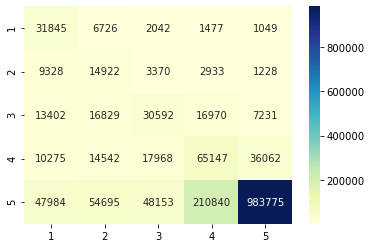

In [17]:
y_train_pred = predict(model, X_train)
metrics(y_train, y_train_pred)

F1 Score : 0.4257627262439847
              precision    recall  f1-score   support

           1       0.31      0.74      0.43     43139
           2       0.18      0.37      0.24     31781
           3       0.53      0.22      0.31     85024
           4       0.21      0.59      0.31    143994
           5       0.95      0.74      0.83   1345447

    accuracy                           0.69   1649385
   macro avg       0.44      0.53      0.43   1649385
weighted avg       0.83      0.69      0.74   1649385



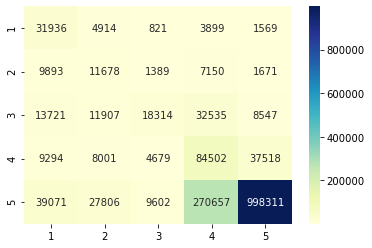

In [18]:
y_train_pred2 = predict(model, X_train, tweak_proba=True)
metrics(y_train, y_train_pred2)

In [19]:
y_test_pred = predict(model, X_test)

df_submission = pd.concat([pd.Series(list(range(1,60428)), name='review_id', dtype=np.int32), pd.Series(y_test_pred, name='rating')], axis=1)
df_submission.to_csv('submission.csv', index=False)

df_submission

,review_id,rating
0,1,3
1,2,3
2,3,2
3,4,5
4,5,5
...,...,...
60422,60423,4
60423,60424,1
60424,60425,4
60425,60426,5


In [20]:
y_test_pred2 = predict(model, X_test, tweak_proba=True)

df_submission2 = pd.concat([pd.Series(list(range(1,60428)), name='review_id', dtype=np.int32), pd.Series(y_test_pred2, name='rating')], axis=1)
df_submission2.to_csv('submission_tweak_proba.csv', index=False)

df_submission2

,review_id,rating
0,1,3
1,2,5
2,3,4
3,4,5
4,5,5
...,...,...
60422,60423,4
60423,60424,1
60424,60425,4
60425,60426,5
